# Import Libraries

In [105]:
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import cv2

# Image Loader

In [106]:
def load_image(url, grayscale=True):
    """
    Load image from url in color or grayscale.

    url: string
    grayscale: boolean
    """

    # Fetch image data and convert to numpy array
    response = urllib.request.urlopen(url)
    image_data = np.asarray(bytearray(response.read()), dtype=np.uint8)

    # Convert image to GRAYSCALE or RGB
    if grayscale:
        img = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

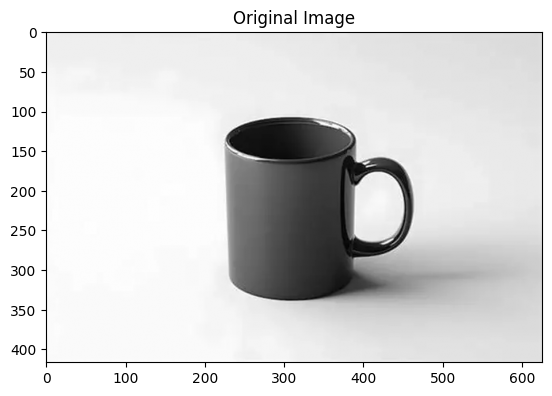

In [107]:
# URLs of testing images
elephant_url = "https://1.bp.blogspot.com/-B1qPgqddbsE/XzfS3q4b9hI/AAAAAAAAAN0/ZBujuubx-_ElUaMOx75ECYVBGgWfBidvgCLcBGAsYHQ/s2048/elephant+2.jpg"
cup_url = "https://tse3.mm.bing.net/th/id/OIP.aP6Kruk6rSx8vuX4YIc3pgHaE7?w=626&h=417&rs=1&pid=ImgDetMain&o=7&rm=3"

# Load testing images
elephant_image = load_image(elephant_url)
cup_image = load_image(cup_url)

# Display testing images
plt.imshow(cup_image, cmap='gray')
plt.title("Original Image")
plt.show()

# Segmentation

In [108]:
def otsu_segmentation(image):

  # Fetch image characteristics
  rows, cols = image.shape
  total_pixels = rows * cols

  # Compute intensity occurences (histogram) and total intensity
  intensity_occurences = [0] * 256
  total_intensity = 0

  for i in range(rows):
    for j in range(cols):
      intensity = int(image[i, j])
      intensity_occurences[intensity] += 1
      total_intensity += intensity

  # Compute global mean
  global_mean = total_intensity / total_pixels

  # Compute cumulative weight and mean for different tresholds
  cumulative_weight = [0] * 256
  cumulative_mean = [0.0] * 256
  current_weight = 0
  current_mean = 0

  for t in range(256):
    current_weight += intensity_occurences[t] / total_pixels
    current_mean += (t * intensity_occurences[t]) / total_pixels

    cumulative_weight[t] = current_weight
    cumulative_mean[t] = current_mean

  # Check which threshold minimizes intraclass variance
  min_within_class_var = float('inf')
  best_threshold = 0

  for t in range (256):
    weight_bg = cumulative_weight[t]
    weight_fg = 1 - cumulative_weight[t]

    eps = 1e-12
    if weight_bg < eps or weight_fg < eps:
      continue

    # Calculate background mean and variance
    mean_bg = cumulative_mean[t]
    var_bg = 0.0
    for i in range(0, t+1):
      var_bg += (((i - mean_bg) ** 2) * intensity_occurences[i]) / total_pixels

    # Calculate foreground mean and variance
    mean_fg = (global_mean - (weight_bg * mean_bg)) / weight_fg
    var_fg = 0.0
    for i in range(t+1, 256):
      var_fg += (((i - mean_fg) ** 2) * intensity_occurences[i]) / total_pixels

    # Calculate and evaluate weighted average of intraclass variances
    within_class_var = weight_bg * var_bg + weight_fg * var_fg
    if within_class_var < min_within_class_var:
      min_within_class_var = within_class_var
      best_threshold = t

  # Perform segmentation using optimal threshold
  mask = (image <= best_threshold) * 255

  return mask.astype(np.uint8)

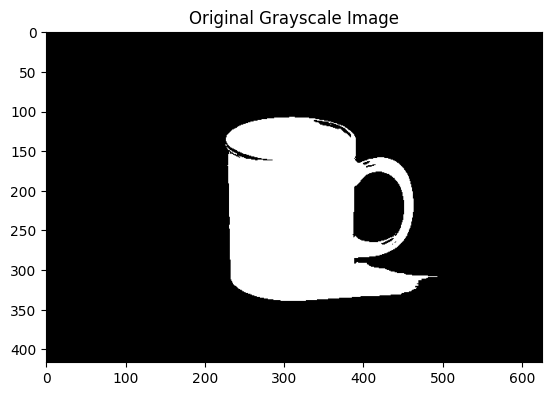

In [109]:
mask = otsu_segmentation(cup_image)

# Display mask
plt.imshow(mask, cmap='gray')
plt.title("Original Grayscale Image")
plt.show()

# Morphological Operations

In [110]:
# Define the default structuring element
default_SE = np.ones((3, 3), dtype=np.uint8)

In [111]:
def pad_image(image, se=default_SE):
  padding_h = se.shape[0] // 2
  padding_w = se.shape[1] // 2
  padded_image = np.pad(image, ((padding_h, padding_h), (padding_w, padding_w)), mode='constant', constant_values=0)

  return padded_image

In [112]:
def erosion(image, se=default_SE):

  # Fetch image and SE characteristics
  image_h, image_w = image.shape
  se_h, se_w = se.shape

  # Pad image and initialize output
  padded_image = pad_image(image, se)
  output = np.zeros_like(image)

  # Slide SE over padded image
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      region = padded_image[i:i+se_h, j:j+se_w]

      # Perform the Morphological Operation
      if np.all(region[se == 1] == 255):
        output[i, j] = 255

  return output

In [113]:
def dilation(image, se=default_SE):

  # Fetch image and SE characteristics
  image_h, image_w = image.shape
  se_h, se_w = se.shape

  # Pad image and initialize output
  padded_image = pad_image(image, se)
  output = np.zeros_like(image)

  # Slide SE over padded image
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      region = padded_image[i:i+se_h, j:j+se_w]

      # Perform the Morphological Operation
      if np.any(region[se == 1] == 255):
        output[i, j] = 255

  return output

In [114]:
def opening(image, se=default_SE, iter=1):
  current = image
  for i in range(iter):
    eroded = erosion(current, se)
    opened = dilation(eroded, se)
    current = opened

  return current

In [115]:
def closing(image, se=default_SE, iter=1):
  current = image
  for i in range(iter):
    dilated = dilation(current, se)
    closed = erosion(dilated, se)
    current = closed

  return current

# Test Morphological Operations

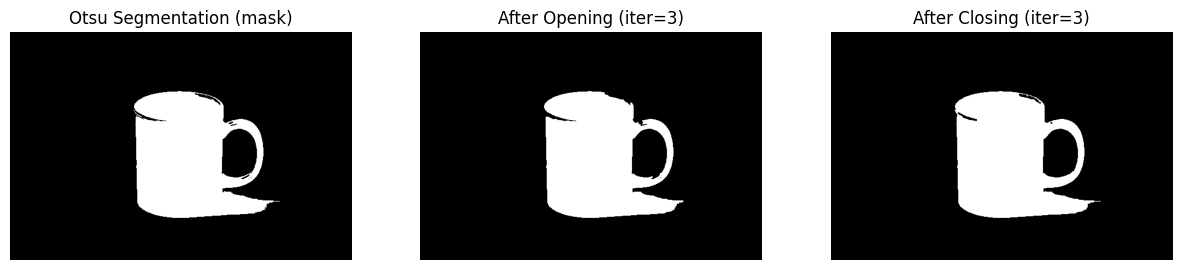

In [116]:
mask = otsu_segmentation(cup_image)

opened_mask = opening(mask, default_SE, iter=3)
closed_mask = closing(mask, default_SE, iter=3)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(mask, cmap='gray')
plt.title("Otsu Segmentation (mask)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(opened_mask, cmap='gray')
plt.title("After Opening (iter=3)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(closed_mask, cmap='gray')
plt.title("After Closing (iter=3)")
plt.axis('off')

plt.show()


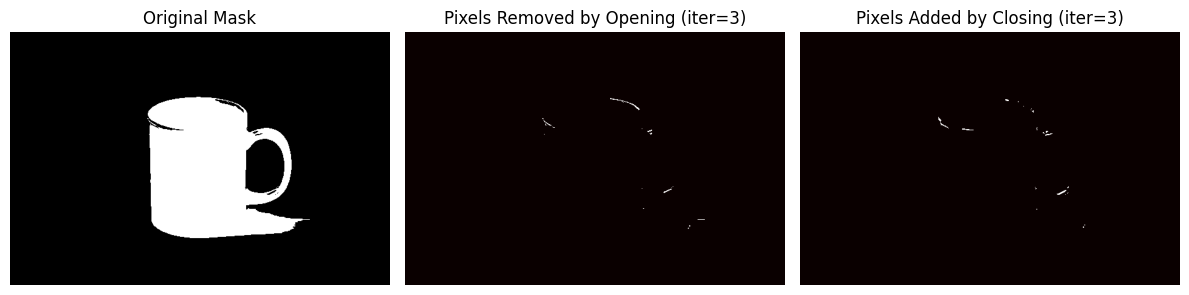

In [117]:
mask = otsu_segmentation(cup_image)

opened_mask = opening(mask, default_SE, iter=3)
closed_mask = closing(mask, default_SE, iter=3)

# Compute what changed
removed_by_open = np.clip((mask.astype(int) - opened_mask.astype(int)), 0, 255).astype('uint8')
added_by_close  = np.clip((closed_mask.astype(int) - mask.astype(int)), 0, 255).astype('uint8')

# Visualize results
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap='gray')
plt.title("Original Mask")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(removed_by_open, cmap='hot')
plt.title(f"Pixels Removed by Opening (iter=3)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(added_by_close, cmap='hot')
plt.title(f"Pixels Added by Closing (iter=3)")
plt.axis('off')

plt.tight_layout()
plt.show()